In [1]:
import huggingface_hub
huggingface_hub.login()


Loading model: BanglaASR


Device set to use cpu


Evaluating on dataset: Common Voice bn


Reading metadata...: 9327it [00:02, 4483.48it/s]
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating Common Voice bn: 10it [04:29, 26.99s/it]


Evaluating on dataset: Common Voice en


Reading metadata...: 16393it [00:02, 5812.08it/s]
Evaluating Common Voice en: 10it [03:28, 20.81s/it]



Loading model: Whisper-small


Device set to use cpu


Evaluating on dataset: Common Voice bn


Reading metadata...: 9327it [00:02, 4022.01it/s]
Evaluating Common Voice bn: 10it [05:22, 32.25s/it]


Evaluating on dataset: Common Voice en


Reading metadata...: 16393it [00:02, 5765.94it/s]
Evaluating Common Voice en: 10it [05:31, 33.10s/it]


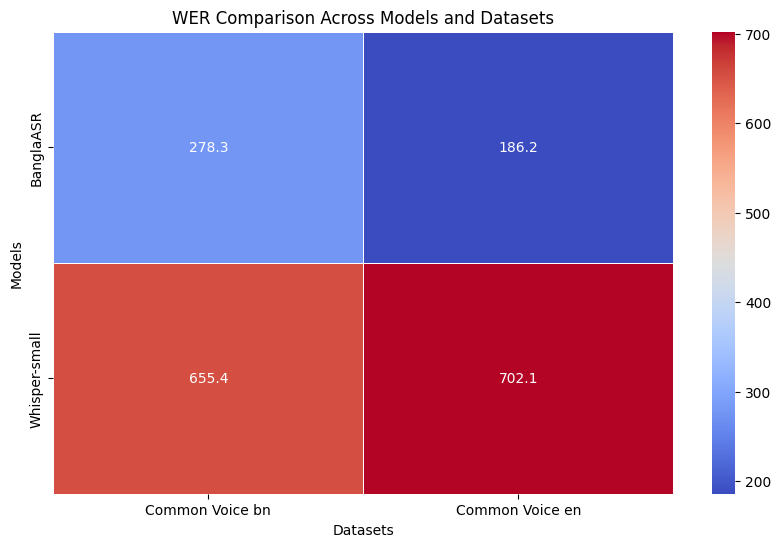

In [2]:
import torch
from transformers import pipeline, AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset
import jiwer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Text normalization transform
wer_transform = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords()
])

def calculate_wer(references, predictions):
    try:
        return jiwer.wer(
            references,
            predictions,
            truth_transform=wer_transform,
            hypothesis_transform=wer_transform
        )
    except:
        return float('inf')

# Model configurations
MODEL_CONFIGS = [
    {
        "name": "BanglaASR",
        "model_id": "bangla-speech-processing/BanglaASR",
        "torch_dtype": torch.float32,
        "device": "cpu",
        "pipeline_args": {
            "chunk_length_s": 30,
            "stride_length_s": (4, 2),
            "generate_kwargs": {"language": "<|bn|>", "task": "transcribe"}
        }
    },
    {
        "name": "Whisper-small",
        "model_id": "openai/whisper-small",
        "torch_dtype": torch.float32,
        "device": "cpu",
        "pipeline_args": {
            "chunk_length_s": 30,
            "stride_length_s": (4, 2),
            "generate_kwargs": {"language": "bn", "task": "transcribe"}
        }
    }
]

# Dataset configurations (Only Common Voice bn and en)
DATASET_CONFIGS = [
    {
        "name": "Common Voice bn",
        "path": "mozilla-foundation/common_voice_17_0",
        "config": "bn",
        "split": "test",
        "text_key": "sentence"
    },
    {
        "name": "Common Voice en",
        "path": "mozilla-foundation/common_voice_17_0",
        "config": "en",
        "split": "test",
        "text_key": "sentence"
    }
]

def load_model_and_processor(model_config):
    """Load model and processor from Hugging Face Hub."""
    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model_config["model_id"],
        torch_dtype=model_config.get("torch_dtype", torch.float32),
        trust_remote_code=True
    )
    processor = AutoProcessor.from_pretrained(
        model_config["model_id"],
        trust_remote_code=True
    )
    return model, processor

def create_pipeline(model, processor, model_config):
    """Create ASR pipeline with model-specific settings."""
    return pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        device=model_config.get("device", "cpu"),
        torch_dtype=model_config.get("torch_dtype", torch.float32),
    )

def evaluate_dataset(dataset_config, pipe, pipeline_args, sample_size=20):
    """Evaluate a single model on a dataset with streaming enabled."""
    try:
        dataset = load_dataset(
            dataset_config["path"],
            dataset_config.get("config"),
            split=dataset_config["split"],
            streaming=True
        ).shuffle(seed=42).take(sample_size)
    except Exception as e:
        print(f"Error loading {dataset_config['name']}: {str(e)}")
        return None

    predictions, references = [], []

    for sample in tqdm(dataset, desc=f"Evaluating {dataset_config['name']}"):
        try:
            audio = sample["audio"]["array"]
            if audio.size == 0 or audio.ndim != 1:
                raise ValueError("Invalid audio format")

            text = sample.get(dataset_config["text_key"], "").strip()
            if not text:
                raise ValueError("Invalid text format")

            result = pipe(audio, **pipeline_args)
            prediction = result["text"].strip()

            references.append(text)
            predictions.append(prediction)
        except Exception as e:
            print(f"Error processing sample: {str(e)}")
            continue

    if len(references) == 0:
        return None

    wer = 100 * calculate_wer(references, predictions)
    return {
        "samples_tested": len(references),
        "WER (%)": wer
    }

# Main evaluation loop
results = []
for model_config in MODEL_CONFIGS:
    try:
        print(f"\nLoading model: {model_config['name']}")
        model, processor = load_model_and_processor(model_config)
        pipe = create_pipeline(model, processor, model_config)
        pipeline_args = model_config.get("pipeline_args", {})
        
        for dataset_config in DATASET_CONFIGS:
            print(f"Evaluating on dataset: {dataset_config['name']}")
            result = evaluate_dataset(dataset_config, pipe, pipeline_args, sample_size=10)
            if result:
                results.append({
                    "model": model_config["name"],
                    "dataset": dataset_config["name"],
                    **result
                })
    except Exception as e:
        print(f"Error with model {model_config['name']}: {str(e)}")
        continue

# Visualization
if results:
    df = pd.DataFrame(results)
    df_pivot = df.pivot(index="model", columns="dataset", values="WER (%)")
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_pivot, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
    plt.title("WER Comparison Across Models and Datasets")
    plt.xlabel("Datasets")
    plt.ylabel("Models")
    plt.show()
else:
    print("No results to display")
